In [60]:
%pylab inline
%precision 4

Populating the interactive namespace from numpy and matplotlib


'%.4f'

This notebook contains code to reproduce the following from Mitra, et al.:


**Supplementary Figures:** 
* Supplementary Figure X: Mutation burden for GWAS SNPs in ASD, SCZ, EA


In [61]:
# Input per-locus info
LOCFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.locus_stats.tab"

# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

MUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/SSC_allphases_072820_denovos_model_X.denovos.final_qc_mutations.tab"
NAIVEMUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_072820_denovos_naive_X.denovos.final_qc_mutations.tab"


# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_het.tab"
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"
SFARIFILE = "/storage/mgymrek/ssc-denovos/annotations/SFARI-Gene_genes_08-29-2019release_09-11-2019export.csv"
JACKGENES = "/storage/mgymrek/ssc-denovos/annotations/jack_102genes.txt"

# GWAS data
ASDFILE = "/storage/ileena/denovos5/ASD_GWAS_iPSYC_PGC/ALL_ASD_GWAS_50000.bed"
SCZFILE = "/storage/ileena/denovos5/SCZ_GWAS/SCZ_50000.bed"
EAFILE = "/storage/ileena/denovos5/SCZ_GWAS/EA_50000.bed"

# Output path info
OUTDIR = "/storage/ileena/pdfs/"

In [67]:
# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])
alldata = pd.concat([alldata,pd.read_csv(MUTFILEX, sep="\t")], sort=False)
alldata = alldata[alldata.family.isin(usefams)]


# Load expansions identified using naive method
ndata = pd.concat([pd.read_csv(NAIVEMUTFILE, sep="\t"),
                   pd.read_csv(NAIVEMUTFILEX, sep="\t")], sort=False)
# moderately big expansion events
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)].copy() 

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata]).drop_duplicates()


# Manually remove remaining problematic families.
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]


# Age data
ages = pd.read_csv(AGEFILE)
ages["family"] = ages["fam_id"]
ages["child"] = ages["sample_id"]
ages = ages[~np.isnan(ages["father_age_birth"])]


alldata = pd.merge(alldata, ages, on=["family", "child"], how="left")

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata = alldata[alldata.chrom!="X"] #don't include X
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

# Get age info
ages = pd.read_csv(AGEFILE)
ages["family"] = ages["fam_id"]
ages["child"] = ages["sample_id"]
ages["phenotype"] = ages["ssc_id"].apply(lambda x: [1,2]["p1" in x])
ages = ages[~np.isnan(ages["father_age_birth"])]

In [68]:
# Get Allele freq info
het = pd.read_csv(HETFILE, sep="\t")
het["chrom"] = het["chrom"].apply(GetChrom)

afreq = pd.read_csv(AFREQFILE, sep="\t")
afreq.columns = ["chrom","pos","newallele","count"]
afreq["chrom"] = afreq["chrom"].apply(GetChrom)
afreq = pd.merge(afreq, het[["chrom","pos","total"]], on=["chrom","pos"])
afreq["freq"] = afreq.apply(lambda x: float(x["count"])/x["total"], 1)

fdata = pd.merge(adata, afreq, on=["chrom","pos","newallele"], how="left")
fdata.ix[np.isnan(fdata["freq"]),"freq"] = 0
fdata.ix[np.isnan(fdata["count"]),"count"] = 0

fdata = pd.merge(fdata, het[["chrom","pos","het"]], on=["chrom","pos"], how="left")

finaldata = pd.merge(fdata, ages[["family","child","sex","father_age_birth_years"]], on=["family","child"], how="left")
finaldata.chrom = finaldata.chrom.astype(str)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [69]:
# MERGE GWAS DATA
asd = pd.read_csv(ASDFILE, sep="\s+", header=None, names=["snp_chr", "snp_pos", "chrom", "pos", "bp_overlap"], low_memory=False)
asd = asd[asd.chrom != "X"]
asd.chrom = asd.chrom.astype(int)

scz = pd.read_csv(SCZFILE, sep="\s+", header=None, names=["snp_chr", "snp_pos", "chrom", "pos", "bp_overlap"], low_memory=False)
scz = scz[scz.chrom != "X"]
scz.chrom = scz.chrom.astype(int)

ea = pd.read_csv(EAFILE, sep="\s+", header=None, names=["snp_chr", "snp_pos", "chrom", "pos", "bp_overlap"], low_memory=False)
ea = ea[ea.chrom != "X"]
ea.chrom = ea.chrom.astype(int)



In [70]:
AFF_COLOR = "red"
UNAFF_COLOR = "blue"

def GetCounts(df, pt, families, sex=None):
    famcounts = {}
    counts = df[df["phenotype"]==pt]
    if sex is not None:
        counts = counts[counts["sex"]==sex]
    for i in range(counts.shape[0]):
        fam = counts["family"].values[i]
        count = counts["nummut"].values[i]
        famcounts[fam] = count
    mutcounts = [famcounts.get(family, 0) for family in families]
    return mutcounts


def PlotBurden(full_fdata, fdata_list, fdata_list_labels, col=None, freq=1, figprefix=None, adjust_patage=False):
    fdata = full_fdata
    
    # Get list of families to use
    families = set(fdata["family"])

    pt_counts_list_unaff = []
    pt_stderrs_list_unaff = []
    pt_counts_list_aff = []
    pt_stderrs_list_aff = []
   
    perc_mut_aff_all_list = []
    total_mut_all_list = []
      
    sizes_means_list_unaff = []
    sizes_stderrs_list_unaff = []
    sizes_means_list_aff = []
    sizes_stderrs_list_aff = []
      
    for i in range(len(fdata_list)):
        fdata = fdata_list[i]
        flabel = fdata_list_labels[i]
        usedata = fdata[(fdata["freq"]<=freq)]
        if col is not None:
            usedata = usedata[(usedata[col]>0)]
        child_counts = usedata.groupby(["child","phenotype","family"], as_index=False).agg({"posterior": len})
        child_counts.columns = ["child","phenotype","family","nummut"]
   
        aff_counts = GetCounts(child_counts, 2, families)
        unaff_counts = GetCounts(child_counts, 1, families)
     
        pt_counts = np.array([np.mean(unaff_counts), np.mean(aff_counts)])
        pt_stderrs = np.array([np.sqrt(np.var(unaff_counts)/len(families)), np.sqrt(np.var(aff_counts)/len(families))])
    
        # Update data lists
        pt_counts_list_unaff.append(np.mean(unaff_counts))
        pt_counts_list_aff.append(np.mean(aff_counts))
        pt_stderrs_list_unaff.append(np.sqrt(np.var(unaff_counts)/len(families)))
        pt_stderrs_list_aff.append(np.sqrt(np.var(aff_counts)/len(families)))
          
        # P-values
        print("***Test burden - %s"%flabel)
        print("num total muts=%s"%usedata.shape[0])
        print("num total TR loci=%s"%len(usedata[["chrom", "pos"]].drop_duplicates()))

        print(len(unaff_counts))
        print("Unaff mean=%s"%np.mean(unaff_counts))
        print("Aff mean=%s"%np.mean(aff_counts))
        try:
            print(scipy.stats.mannwhitneyu(unaff_counts, aff_counts,  alternative="less"))
            print(scipy.stats.ttest_rel(unaff_counts, aff_counts))
        except: pass
        # odds ratios
        print("***Odds ratios")
        or_all = np.mean(aff_counts)/np.mean(unaff_counts)
        print("all=%s"%or_all)
        print("num proband all=%s"%len(aff_counts))
        print("num unaff all=%s"%len(unaff_counts))
          
        total_mut_all_list.append(np.sum(aff_counts)+np.sum(unaff_counts))
        perc_mut_aff_all_list.append(np.sum(aff_counts)/(np.sum(aff_counts)+np.sum(unaff_counts)))
         
        
        ### Compute genome-wide p-value, adjusting for age of father ###
        if adjust_patage:
            child_counts = usedata.groupby(["child","phenotype","family","father_age_birth_years"], as_index=False).agg({"posterior": len})
            child_counts.columns = ["child","phenotype","family","father_age_birth_years","nummut"]

            unaff_counts = child_counts[child_counts["phenotype"]==1]
            X = sm.add_constant(np.array(unaff_counts[["father_age_birth_years"]]))
            Y = np.array(unaff_counts["nummut"])
            model = sm.OLS(Y, X).fit()

            # Predict and get residuals for all
            child_counts["pred_nummut"] = model.predict(sm.add_constant(np.array(child_counts[["father_age_birth_years"]])))
            child_counts["resid_nummut"] = child_counts["nummut"]-child_counts["pred_nummut"]

            # Compute p-val
            print("***Test burden - adjust for age of father")
            print(scipy.stats.mannwhitneyu(child_counts[child_counts["phenotype"]==1]["resid_nummut"],
                            child_counts[child_counts["phenotype"]==2]["resid_nummut"],  alternative="less"))
            print(scipy.stats.ttest_rel(child_counts[child_counts["phenotype"]==1].sort_values("family")["resid_nummut"],
                            child_counts[child_counts["phenotype"]==2].sort_values("family")["resid_nummut"]))

    ########### Main bar plot showing diff ############
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 5))
    ax = fig.add_subplot(111)
    
    # Plot overall
    W = 0.2
    xvals = range(len(fdata_list))
    ax.bar(xvals, pt_counts_list_unaff, yerr=1.96*np.array(pt_stderrs_list_unaff), color=UNAFF_COLOR, width=W)
    ax.bar([item+W for item in xvals], pt_counts_list_aff, yerr=1.96*np.array(pt_stderrs_list_aff), color=AFF_COLOR, width=W)


    # Hide the right and top spines
    ax.set_xticks([item+W/2 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    ax.set_ylabel("# mutations/child", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    
    ax.set_title(col)
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-burden.pdf"))
    

# Supp Fig. Mutation burden - GWAS SNPs

***Test burden - asd
num total muts=4213
num total TR loci=1464
1593
Unaff mean=1.305084745762712
Aff mean=1.3396107972379159
MannwhitneyuResult(statistic=1253057.5, pvalue=0.2612892022341798)
Ttest_relResult(statistic=-0.49199506123374215, pvalue=0.6227906670664038)
***Odds ratios
all=1.0264550264550263
num proband all=1593
num unaff all=1593
***Test burden - scz
num total muts=22811
num total TR loci=5780
1593
Unaff mean=7.008788449466415
Aff mean=7.3107344632768365
MannwhitneyuResult(statistic=1219152.0, pvalue=0.02755322523702097)
Ttest_relResult(statistic=-1.4565982163955082, pvalue=0.14542451189707614)
***Odds ratios
all=1.0430810568741604
num proband all=1593
num unaff all=1593
***Test burden - ea
num total muts=25668
num total TR loci=7058
1593
Unaff mean=7.894538606403013
Aff mean=8.218455743879472
MannwhitneyuResult(statistic=1215454.0, pvalue=0.01968328688837132)
Ttest_relResult(statistic=-1.8512394080844, pvalue=0.06432020837723162)
***Odds ratios
all=1.041030534351145
num 

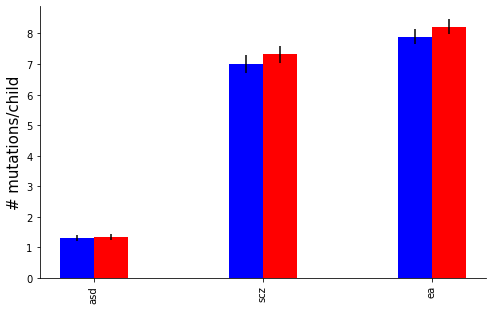

In [72]:
##### GWAS ALL
fdata_list = []
fdata_labels_list = ["asd", "scz", "ea"]
for df in [asd, scz, ea]:
    finaldata.chrom = finaldata.chrom.astype(int)
    df.chrom = df.chrom.astype(int)
    fdata_list.append(pd.merge(finaldata, df, on=["chrom", "pos"]))
PlotBurden(finaldata, fdata_list, fdata_labels_list, col=None, freq=1, figprefix="FigMutBurden-ByGWAS-All", adjust_patage=False) 




***Test burden - asd_AF05
num total muts=1439
num total TR loci=676
1593
Unaff mean=0.47332077840552417
Aff mean=0.4300062774639046
MannwhitneyuResult(statistic=1286230.5, pvalue=0.807234573808069)
Ttest_relResult(statistic=1.1518791246753637, pvalue=0.24954369659389125)
***Odds ratios
all=0.9084880636604774
num proband all=1593
num unaff all=1593
***Test burden - scz_AF05
num total muts=8149
num total TR loci=2696
1593
Unaff mean=2.5731324544883867
Aff mean=2.542372881355932
MannwhitneyuResult(statistic=1271380.5, pvalue=0.5400890217519598)
Ttest_relResult(statistic=0.2606247221997597, pvalue=0.7944156288802428)
***Odds ratios
all=0.9880458648450842
num proband all=1593
num unaff all=1593
***Test burden - ea_AF05
num total muts=9304
num total TR loci=3332
1593
Unaff mean=2.924042686754551
Aff mean=2.916509730069052
MannwhitneyuResult(statistic=1264539.5, pvalue=0.43367660066438907)
Ttest_relResult(statistic=0.07215407585629445, pvalue=0.9424883553607559)
***Odds ratios
all=0.997423787

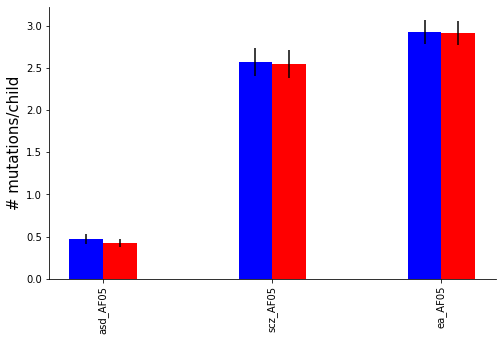

In [75]:
##### GWAS AF > 0.05
fdata_list = []
fdata_labels_list = ["asd_AF05", "scz_AF05", "ea_AF05"]
for df in [asd, scz, ea]:
    finaldata.chrom = finaldata.chrom.astype(int)
    df.chrom = df.chrom.astype(int)
    fdata_list.append(pd.merge(finaldata, df, on=["chrom", "pos"]))
PlotBurden(finaldata, fdata_list, fdata_labels_list, freq=0.05, col=None, figprefix="FigMutBurden-ByGWAS-AF05", adjust_patage=False) 


